In [143]:
from quasinet.qnet import load_qnet
from quasinet.qnet import save_qnet
from quasinet.qsampling import qsample
from quasinet.qnet import qdistance, qdistance_matrix
from quasinet.qnet import Qnet
from tqdm import tqdm

In [144]:
import pandas as pd
import numpy as np

In [145]:
df1=pd.read_csv('xt.csv')
N=20
# Step 1: Select columns with > N unique entries
cols_to_process = [col for col in df1.columns if df1[col].nunique() > N]

# Step 2: Round/cluster each selected column to N closest values
for col in cols_to_process:
    unique_vals = np.linspace(df1[col].min(), df1[col].max(), N)  # N evenly spaced values
    df1[col] = df1[col].apply(lambda x: unique_vals[np.argmin(np.abs(unique_vals - x))])
dft=df1.copy()
Xt=dft.values.astype('str')

In [162]:
import numpy as np
import pandas as pd

def discretize_columns(df, N=20, method="equal_width", as_categorical=True, cols=None):
    """
    Replace selected numeric columns by discretization *levels* 0..N-1.
    - method: "equal_width" (bins by value range) or "quantile" (approximately equal counts)
    - as_categorical: if True, output dtype is categorical with labels 0..N-1; else int
    - cols: list of columns to consider. If None, auto-select numeric cols with nunique > N
    Returns the transformed DataFrame and a dict of per-column bin edges.
    """
    df_out = df.copy()
    # choose columns
    if cols is None:
        num_cols = df_out.select_dtypes(include=[np.number]).columns
        cols_to_process = [c for c in num_cols if df_out[c].nunique(dropna=True) > N]
    else:
        cols_to_process = cols

    bin_info = {}
    for col in cols_to_process:
        s = df_out[col]

        # Build bin edges
        if method == "equal_width":
            vmin, vmax = s.min(skipna=True), s.max(skipna=True)
            # guard for degenerate range
            if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
                continue
            edges = np.linspace(vmin, vmax, N + 1)
        elif method == "quantile":
            # unique quantiles to avoid duplicate edges with ties
            q = np.linspace(0, 1, N + 1)
            edges = np.unique(s.quantile(q, interpolation="linear"))
            # If we get fewer than N+1 unique edges (heavy ties), fall back to equal_width
            if edges.size < 2:
                continue
            if edges.size != N + 1:
                # pad via equal_width over the observed min/max
                vmin, vmax = s.min(skipna=True), s.max(skipna=True)
                edges = np.linspace(vmin, vmax, N + 1)
        else:
            raise ValueError("method must be 'equal_width' or 'quantile'")

        # Ensure strictly increasing (can happen with constant segments); jitter if needed
        # (pd.cut can handle equal edges poorly)
        eps = np.finfo(float).eps
        for i in range(1, edges.size):
            if edges[i] <= edges[i-1]:
                edges[i] = edges[i-1] + eps

        # Bin -> levels 0..N-1
        # Use pd.cut to keep NaNs as NaN and include lowest edge
        levels = pd.cut(s, bins=edges, labels=range(edges.size - 1),
                        include_lowest=True, right=True)

        if as_categorical:
            df_out[col] = levels.astype("category")
        else:
            # convert to integer codes, leave NaN where missing
            df_out[col] = levels.astype("Int64")  # pandas nullable integer

        # store info: edges and midpoints (representatives)
        mids = (edges[:-1] + edges[1:]) / 2
        bin_info[col] = {"edges": edges, "midpoints": mids}

    return df_out, bin_info

# ---------------- Example ----------------
# df_out has discretization *levels* as entries for selected columns
# bin_info[col]['edges'] gives the boundaries; ['midpoints'] gives representative values
# df_out, bin_info = discretize_columns(df, N=20, method="equal_width", as_categorical=True)
def discretize_df(df, N=20):
    """
    Discretize numeric columns in df that have more than N unique values.
    Replaces entries with integer levels 0..N-1.
    Returns a DataFrame with discretized entries.
    """
    df_out = df.copy()
    cols_to_process = [
        col for col in df_out.select_dtypes(include=[np.number]).columns
        if df_out[col].nunique(dropna=True) > N
    ]

    for col in cols_to_process:
        vmin, vmax = df_out[col].min(skipna=True), df_out[col].max(skipna=True)
        if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
            continue
        # N equal-width bins over the observed range
        edges = np.linspace(vmin, vmax, N + 1)
        # Assign bin indices (0..N-1), NaN stays NaN
        df_out[col] = pd.cut(df_out[col], bins=edges, labels=False, include_lowest=True)

    return df_out

In [180]:
df1=pd.read_csv('xg.csv')
dfg=discretize_df(df1)
Xg=dfg.values.astype(str)

df2=pd.read_csv('xt.csv')
dft=discretize_df(df2)
Xt=dft.values.astype(str)


In [166]:
feature_names=dft.columns.values

In [167]:
%%time
modelt=Qnet(feature_names=dft.columns.values,alpha=.001)
modelt.fit(Xt)
save_qnet(modelt,'modelt',gz=True)

CPU times: user 1min 9s, sys: 614 ms, total: 1min 9s
Wall time: 1min 10s


In [168]:
%%time
modelg=Qnet(feature_names=dfg.columns.values,alpha=.001)
modelg.fit(Xg)
save_qnet(modelg,'modelg',gz=True)

CPU times: user 40.3 s, sys: 211 ms, total: 40.5 s
Wall time: 40.8 s


In [169]:
NULL=np.array(['']*len(feature_names)).astype('U100')

In [170]:
def getbp(s):
    # generate a vector summing to 1.0 with zeros where 
    # the response/observation is missing
    # so that we can perturb only in entries which are non-missing
    bp=np.ones(len(s))
    bp[np.where(s=='')[0]]=0
    return bp/bp.sum()

In [171]:
N=100
steps=10

In [153]:
# LSM synthetic generation
#gensamplest=[qsample(s,modelt,steps=steps,alpha=1,baseline_prob=getbp(s)) for s in tqdm(Xt[:N])]
Xtt=dft.sample(N).values.astype('str')
ergdispt=np.array([qdistance(NULL,s,modelt,modelt) for s in tqdm(Xtt)])

100%|█████████████████████████████████████████| 100/100 [00:01<00:00, 54.25it/s]


In [154]:
# LSM synthetic generation
#gensamplesg=[qsample(s,modelg,steps=steps,alpha=1,baseline_prob=getbp(s)) for s in tqdm(Xg[:N])]
Xgg=dfg.sample(N).values.astype('str')
ergdispg=np.array([qdistance(NULL,s,modelg,modelt) for s in tqdm(Xgg)])

100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 44.00it/s]


In [155]:
import seaborn as sns

<Axes: ylabel='Density'>

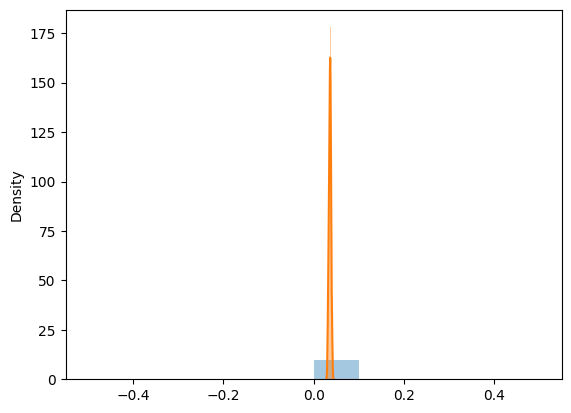

In [156]:
sns.distplot(ergdispt)
sns.distplot(ergdispg)

In [183]:
df1.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906,0.001953,0.000977,0.000488,0.000244,0.000122,0.000061
1,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007813,0.003906,0.001953,0.000977,0.000488,0.000244,0.000122
2,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906,0.001953,0.000977,0.000488,0.000244
3,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007813,0.003906,0.001953,0.000977,0.000488
4,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906,0.001953,0.000977
5,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007813,0.003906,0.001953
6,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906
7,0.007812,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812
8,0.003906,0.007813,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625
9,0.001953,0.003906,0.007812,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250


In [184]:
df2.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906,0.001953,0.000977,0.000488,0.000244,0.000122,0.000061
1,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007813,0.003906,0.001953,0.000977,0.000488,0.000244,0.000122
2,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906,0.001953,0.000977,0.000488,0.000244
3,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906,0.001953,0.000977,0.000488
4,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007813,0.003906,0.001953,0.000977
5,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007813,0.003906,0.001953
6,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812,0.003906
7,0.007812,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625,0.007812
8,0.003906,0.007813,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250,0.015625
9,0.001953,0.003906,0.007812,0.015625,0.031250,0.062500,0.125000,0.250000,0.500000,1.000000,0.500000,0.250000,0.125000,0.062500,0.031250


In [122]:
from scipy.stats import ks_2samp

alpha=1e-5
# KS two-sample test
stat, p_val = ks_2samp(ergdispt,ergdispg)
print('comparing original and synthetic data')
print(f"KS Statistic: {stat:.4f}, p-value: {p_val:.4g}")

if p_val < alpha:
    print("Reject null hypothesis: distributions differ.")
else:
    print("Fail to reject null hypothesis: distributions are similar.")

comparing original and synthetic data
KS Statistic: 0.1800, p-value: 0.07822
Fail to reject null hypothesis: distributions are similar.


In [123]:
ergdispg.std(),ergdispt.std()

(0.0021360457693151637, 0.0022813367891247826)

In [124]:
ergdispg.mean(),ergdispt.mean()

(0.036704470120951266, 0.03618989400427858)

In [173]:
modelg.predict_distributions(NULL)[0]

{'5': 0.034625,
 '13': 0.05475,
 '7': 0.101,
 '3': 0.00425,
 '10': 0.159125,
 '14': 0.023875,
 '15': 0.01275,
 '8': 0.134,
 '4': 0.01575,
 '18': 0.000375,
 '6': 0.06575,
 '2': 0.003,
 '19': 0.000125,
 '1': 0.00025,
 '12': 0.09675,
 '11': 0.131625,
 '0': 0.000375,
 '17': 0.001,
 '9': 0.155625,
 '16': 0.005}

In [174]:
modelt.predict_distributions(NULL)[0]

{'5': 0.004125,
 '13': 0.041125,
 '7': 0.029125,
 '3': 0.001625,
 '10': 0.2795,
 '14': 0.01475,
 '15': 0.005875,
 '8': 0.08325,
 '4': 0.001625,
 '18': 0.00025,
 '6': 0.00975,
 '2': 0.00025,
 '19': 0.00025,
 '1': 0.000125,
 '12': 0.108625,
 '11': 0.22975,
 '0': 0.0005,
 '17': 0.001,
 '9': 0.1865,
 '16': 0.002}

In [197]:
Dt=[qdistance(NULL,s,modelg,modelg) for s in tqdm(Xt[:300])]
Dg=[qdistance(NULL,s,modelg,modelg) for s in tqdm(Xg[:300])]


100%|█████████████████████████████████████████| 300/300 [00:04<00:00, 64.37it/s]


In [199]:
from scipy.stats import ks_2samp

alpha=1e-5
# KS two-sample test
stat, p_val = ks_2samp(Dt,Dg)
print('comparing original and synthetic data')
print(f"KS Statistic: {stat:.4f}, p-value: {p_val:.4g}")

if p_val < alpha:
    print("Reject null hypothesis: distributions differ.")
else:
    print("Fail to reject null hypothesis: distributions are similar.")

comparing original and synthetic data
KS Statistic: 0.1333, p-value: 0.009589
Fail to reject null hypothesis: distributions are similar.


<Axes: >

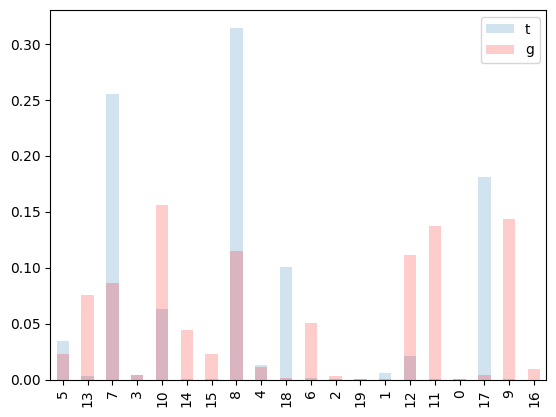

In [209]:
ax=pd.DataFrame(modelt.predict_distributions(NULL)[10],index=['t']).T.plot(kind='bar',alpha=.2)
pd.DataFrame(modelg.predict_distributions(NULL)[10],index=['g']).T.plot(ax=ax,kind='bar',color='r',alpha=.2)


In [214]:
len(Xt)

8000

In [226]:
M=14
d=[(pd.DataFrame(modelt.predict_distributions(NULL)[i],index=['t']).T - pd.DataFrame(modelg.predict_distributions(NULL)[i],index=['t']).T).values.mean() for i in range(M)]

In [227]:
d

[8.239936510889833e-19,
 nan,
 nan,
 5.204170427930421e-19,
 -1.6479873021779667e-18,
 nan,
 nan,
 nan,
 nan,
 -1.7347234759768072e-19,
 nan,
 nan,
 nan,
 nan]

In [241]:

s=NULL

d=np.array([(pd.DataFrame(modelt.predict_distributions(s)[i],index=['t']).T 
 - pd.DataFrame(modelg.predict_distributions(s)[i],index=['t']).T).mean().values[0] for i in range(14)])

In [242]:
d.max()

0.002515624999999997

<Axes: ylabel='Density'>

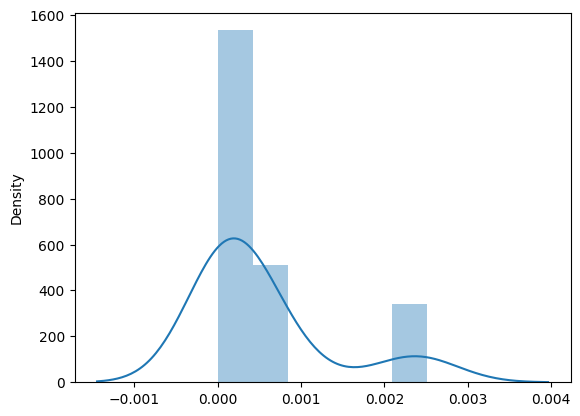

In [243]:
sns.distplot(d)